# Introduction

This notebook contains all code that has been used to analyze the model runs for the "Never train an LSTM on a single basin" paper by Kratzert et al. (in review). To be able to run this notebook, make sure to download the acompanying data of the paper, as well as the CAMELS US dataset and the Benchmark models that were released for the CAMELS US basins. All links can be found in the data section of the paper.

# Imports

In [2]:
import more_itertools
import pickle
from pathlib import Path
from typing import Tuple

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import xarray as xr
from scipy.stats import wilcoxon
from tqdm.notebook import tqdm
from tensorboard.backend.event_processing import event_accumulator

from neuralhydrology.datasetzoo import camelsus
from neuralhydrology.evaluation import metrics as metrics_lib
from neuralhydrology.evaluation import utils as nh_eval_utils


# Global variables

Make sure to adapt the paths below according to your local copy of the paper data.

In [105]:
# Path to the root directory of the provided data of the paper.
PAPER_DIR = Path("/usr/local/google/home/kratzert/Data/single-basin-vs-regional-model")

# Path to the benchmark models, downloaded from https://www.hydroshare.org/resource/474ecc37e7db45baa425cdb4fc1b61e1/
# The path should point to the directory that contains the extracted per-basin netCDF files.
BENCHMARK_MODEL_DIR = Path("/usr/local/google/home/kratzert/Data/CAMELS_US_benchmark_models")


# Path to CAMELS US directory. Required to load the gauge locations.
CAMELS_DIR = Path("/usr/local/google/home/kratzert/Data/CAMELS_US")

In [106]:
FIGURE_DIR = PAPER_DIR / "figures"
RUN_DIRS = PAPER_DIR / "run_dirs"
if not FIGURE_DIR.is_dir():
    FIGURE_DIR.mkdir()
    print(f"Created empty figure directory at {FIGURE_DIR}")

Created empty figure directory at /usr/local/google/home/kratzert/Data/single-basin-vs-regional-model/figures


# Global plot settings

Note, all figure layouts were optimized for the requirements of HESS publications. That is, all plots are created in the final paper size (either 8.3cm width or 12cm width). It might be better to look at the figures in the saved pdf format than in this notebook.

In [7]:
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['axes.linewidth'] = 0.4
mpl.rcParams['ytick.major.width'] = 0.4
mpl.rcParams['xtick.major.width'] = 0.4
mpl.rcParams['ytick.minor.width'] = 0.4
mpl.rcParams['xtick.minor.width'] = 0.4
mpl.rcParams['xtick.labelsize'] = 5
mpl.rcParams['ytick.labelsize'] = 5
mpl.rcParams['legend.fontsize'] = 4
mpl.rcParams['lines.markersize'] = 2
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams["axes.titlesize"] = 7
mpl.rcParams["grid.color"] = "#eeeeee"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

# Helper functions

In [8]:
def cm2inch(width: float, height: float) -> Tuple[float, float]:
    """Converts figure size from centimeters to inch."""
    inch = 2.54
    return (width / inch, height / inch)

def ecdf(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Calculates empirical cummulative density function."""
    xs = np.sort(x)
    ys = np.arange(1, len(xs) + 1) / float(len(xs))
    return xs, ys

def get_validation_data_as_series(event_file: Path, name: str) -> pd.Series:
    """Returns the validation metrics over epochs as pandas series."""
    ea = event_accumulator.EventAccumulator(str(event_file),
    size_guidance={
        event_accumulator.SCALARS: 0,  # 0 means that all events are loaded
    })
    ea.Reload()
    epochs = []
    values = []
    for event in ea.Scalars('valid/median_nse'):
        epochs.append(event.step)
        values.append(event.value)
        ser = pd.Series(data=values, index=epochs, name=name)
        ser.index.name = "Epoch"
    return ser

def get_test_metrics(run_dir: Path) -> pd.DataFrame:
    """Loads the test metrics into a pandas DataFrame."""
    # We only allow a single test_metrics file. This is the case after we cleaned the 
    # directories to only include the results of the epoch with the highest validation score
    metric_file = more_itertools.one(list((run_dir / "test").glob('*/test_metrics.csv')))
    df = pd.read_csv(metric_file, dtype={'basin': str})
    df.set_index("basin", inplace=True)
    return df

# Literature over time

Search query: LSTM hydrology
Search date: September 18, 2023
Each years number is taking by filtering only publications for the respective year.

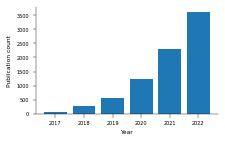

In [9]:
df = pd.DataFrame.from_dict({
    2017: 75,
    2018: 274,
    2019: 571,
    2020: 1230,
    2021: 2300,
    2022: 3620,
}, orient="index", columns=["publication_count"])

fig, ax = plt.subplots(figsize=cm2inch(8.3, 5))
_ = ax.bar(df.index.to_list(), df.publication_count.to_list())
ax.set_xlabel("Year")
ax.set_ylabel("Publication count")
plt.savefig(FIGURE_DIR / "publication_count_over_time.pdf", bbox_inches="tight", format="pdf")

# Single vs regional model

## Load benchmark model results

In [10]:
required_models = ["VIC_basin", "VIC_conus", "mHm_basin", "mHm_conus"]

benchmark_metrics = {m: {} for m in required_models}
for fp in tqdm(BENCHMARK_MODEL_DIR.glob("*.nc")):
    ds = xr.open_dataset(fp)
    if all([m in ds.data_vars for m in required_models]):
        basin = fp.stem.split('_')[0]
        for model in required_models:
            benchmark_metrics[model][basin] = metrics_lib.nse(obs=ds["QObs"], sim=ds[model])

benchmark_df = pd.DataFrame.from_dict(benchmark_metrics, orient="columns")

0it [00:00, ?it/s]

# Load all run data

In [79]:
metrics = ['NSE', 'KGE', 'Pearson-r', 'Alpha-NSE', 'Beta-NSE', 'Beta-KGE', 'Peak-Timing', 'Missed-Peaks']

## Regional model

In [69]:
metrics_dfs_regional = {}

for metric in metrics:
    dfs = []
    for run_dir in tqdm((RUN_DIRS / "regional_model").glob('*')):
        repetition_count = run_dir.name.split('_')[-3]
        df = get_test_metrics(run_dir)
        df.rename(columns={metric: f'regional_model_{repetition_count}'}, inplace=True)
        dfs.append(df[[f'regional_model_{repetition_count}']])

    metrics_dfs_regional[metric] = pd.concat(dfs, axis=1)

df_regional = metrics_dfs_regional['NSE'].copy()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Single basin models

In [16]:
basins = list(set([x.name.split('_')[0][-8:] for x in (RUN_DIRS / "single_basins_multi_forcings").glob('*')]))
num_reps = 10
metrics_reps_series = {metric: {rep: [] for rep in range(num_reps)} for metric in metrics}

for basin in tqdm(basins):
    for run_dir in (RUN_DIRS / "single_basins_multi_forcings").glob(f"basin{basin}_*"):
        repetition_count = run_dir.name.split('_')[-3]
        basin_run_df = get_test_metrics(run_dir)
        for metric in metrics:
            metric_series = basin_run_df[metric].copy().rename(f'single_basin_{repetition_count}')
            metrics_reps_series[metric][int(repetition_count)].append(metric_series)

metrics_dfs_single = {}
for metric in metrics:
    dfs = []
    for rep in range(num_reps):
        dfs.append(pd.concat(metrics_reps_series[metric][rep], axis=0))
    metrics_dfs_single[metric] = pd.concat(dfs, axis=1)

# For backwards compatability
df_single = metrics_dfs_single['NSE'].copy()

  0%|          | 0/529 [00:00<?, ?it/s]

## Size splits

In [17]:
all_sizes = sorted(list(set([int(x.stem.split("_")[1]) for x in (RUN_DIRS / "size_splits").glob('*')])))

size_split_to_df = {}
for size_split in tqdm(all_sizes):
    df_list_1 = []
    for ensemble_count in range(10):
        df_list_2 = []
        for run_dir in (RUN_DIRS / "size_splits").glob(f"size_{size_split}_*_experiment_name_{ensemble_count}*"):
            df = get_test_metrics(run_dir)
            df = df[["NSE"]]  # Only keep NSE column
            df.rename(columns={'NSE': f'size_{size_split}_{ensemble_count}'}, inplace=True)
            df_list_2.append(df)
        df_list_1.append(pd.concat(df_list_2, axis=0))
    size_split_to_df[size_split] = pd.concat(df_list_1, axis=1)

  0%|          | 0/6 [00:00<?, ?it/s]

## Attribute splits

In [18]:
df_list_1 = []
for ensemble_count in tqdm(range(10)):
    df_list_2 = []
    for run_dir in (RUN_DIRS / "attributes_cluster_splits").glob(f"*_experiment_name_{ensemble_count}_*"):
        df = get_test_metrics(run_dir)
        df = df[["NSE"]]
        df.rename(columns={'NSE': f'attribute_cluster_split_{ensemble_count}'}, inplace=True)
        df_list_2.append(df)
    df_list_1.append(pd.concat(df_list_2, axis=0))
df_attribute_splits = pd.concat(df_list_1, axis=1)
        
        

  0%|          | 0/10 [00:00<?, ?it/s]

## HUC split

In [19]:
df_list_1 = []
for ensemble_count in tqdm(range(10)):
    df_list_2 = []
    for run_dir in (RUN_DIRS / "huc_splits").glob(f"*_experiment_name_{ensemble_count}_*"):
        df = get_test_metrics(run_dir)
        df = df[["NSE"]]
        df.rename(columns={'NSE': f'huc_split_{ensemble_count}'}, inplace=True)
        df_list_2.append(df)
    df_list_1.append(pd.concat(df_list_2, axis=0))
df_huc_splits = pd.concat(df_list_1, axis=1)
        
        

  0%|          | 0/10 [00:00<?, ?it/s]

# Benchmark model plot

In [20]:
model_to_plot_def = {
    'VIC_basin': {'color': 'C1', 'ls': '--', 'label': 'VIC (basin)'},
    'VIC_conus': {'color': 'C0', 'ls': '--', 'label': 'VIC (regional)'},
    'mHm_basin': {'color': 'C1', 'ls': '-', 'label': 'mHM (basin)'},
    'mHm_conus': {'color': 'C0', 'ls': '-', 'label': 'mHM (regional)'},
    'lstm_basin': {'color': 'C1', 'ls': '-', 'label': 'LSTM (basin)'},
    'lstm_regional': {'color': 'C0', 'ls': '-', 'label': 'LSTM (regional)'}

}

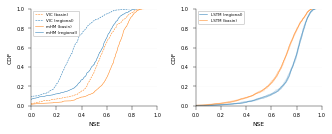

In [107]:
fig, ax = plt.subplots(figsize=cm2inch(12, 5), ncols=2)

# Color definitions
alpha=0.2

# Plot for benchmark models
for model, plot_def in model_to_plot_def.items():
    if model.startswith("lstm"):
        continue
    xs, ys = ecdf(benchmark_df[model])
    ax[0].plot(xs, ys, color=plot_def["color"], ls=plot_def["ls"], label=plot_def["label"])

ax[0].legend()

# Plot LSTM results
for i in range(10):
    xs, ys = ecdf(df_single[f"single_basin_{i}"].values)
    # Only add label for first ensemble member
    if i == 0:
        ax[1].plot(xs, ys, color=model_to_plot_def["lstm_basin"]["color"], ls=model_to_plot_def["lstm_basin"]["ls"], label=model_to_plot_def["lstm_basin"]["label"], alpha=alpha)
    else:
        ax[1].plot(xs, ys, color=model_to_plot_def["lstm_basin"]["color"], ls=model_to_plot_def["lstm_basin"]["ls"], alpha=alpha)

    xs, ys = ecdf(df_regional[f"regional_model_{i}"].values)
    # Only add label for first ensemble member
    if i == 0:
        ax[1].plot(xs, ys, color=model_to_plot_def["lstm_regional"]["color"], ls=model_to_plot_def["lstm_regional"]["ls"], label=model_to_plot_def["lstm_regional"]["label"], alpha=alpha)
    else:
        ax[1].plot(xs, ys, color=model_to_plot_def["lstm_regional"]["color"], ls=model_to_plot_def["lstm_regional"]["ls"], alpha=alpha)

lines_for_legend = [mpl.lines.Line2D([0], [0], color='C0'), mpl.lines.Line2D([0], [0], color='C1')]
labels_for_legend = ['LSTM (regional)', 'LSTM (basin)']
ax[1].legend(lines_for_legend, labels_for_legend)

for i in range(2):
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(0, 1) 
    ax[i].set_xlabel("NSE")
    ax[i].set_ylabel("CDF")
    ax[i].grid(alpha=0.3, axis='y')

fig.tight_layout()

plt.savefig(FIGURE_DIR / "benchmark_vs_lstm_single_vs_regional.pdf", bbox_inches="tight", format="pdf")

# Other Hydrological Metrics

In [80]:
metrics_axis_limits = {
    'NSE': (0, 1),
    'KGE': (0, 1),
    'Pearson-r': (0.5, 1),
    'Alpha-NSE': (0.5, 1.1),
    'Beta-NSE': (-0.1, 0.1),
    'Beta-KGE': (0.5, 1.1),
    'Peak-Timing': (0, 2),
    'Missed-Peaks': (0, 1),
}

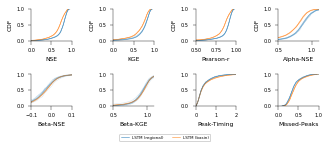

In [81]:
fig, axes = plt.subplots(2, 4, figsize=cm2inch(12, 5))

# Color definitions
alpha=0.2

for ax, metric in zip(axes.flatten(), metrics):
    for i in range(10):
        xs, ys = ecdf(metrics_dfs_single[metric][f"single_basin_{i}"].values)
        if i == 0:
            ax.plot(xs, ys, color=model_to_plot_def["lstm_basin"]["color"], ls=model_to_plot_def["lstm_basin"]["ls"], label=model_to_plot_def["lstm_basin"]["label"], alpha=alpha)
        else:
            ax.plot(xs, ys, color=model_to_plot_def["lstm_basin"]["color"], ls=model_to_plot_def["lstm_basin"]["ls"], alpha=alpha)

        xs, ys = ecdf(metrics_dfs_regional[metric][f"regional_model_{i}"].values)
        if i == 0:
            ax.plot(xs, ys, color=model_to_plot_def["lstm_regional"]["color"], ls=model_to_plot_def["lstm_regional"]["ls"], label=model_to_plot_def["lstm_regional"]["label"], alpha=alpha)
        else:
            ax.plot(xs, ys, color=model_to_plot_def["lstm_regional"]["color"], ls=model_to_plot_def["lstm_regional"]["ls"], alpha=alpha)

        ax.set_xlim(metrics_axis_limits[metric])
        ax.set_ylim(0, 1)
        ax.set_xlabel(metric)
    if ax in axes[0]:
        ax.set_ylabel("CDF")
    
lines_for_legend = [mpl.lines.Line2D([0], [0], color='C0'), mpl.lines.Line2D([0], [0], color='C1')]
labels_for_legend = ['LSTM (regional)', 'LSTM (basin)']

fig.legend(lines_for_legend, labels_for_legend, loc=8, ncol=2)

fig.tight_layout()

plt.savefig(FIGURE_DIR / "other-metrics.pdf", bbox_inches="tight", format="pdf")

# Example hydrograph

## Load data

In [52]:
basin = '13011900'
ensemble_member = 0

run_dir = more_itertools.one(list((RUN_DIRS / "regional_model").glob(f'*_ensemble_member_{ensemble_count}*')))
test_data_file = more_itertools.one(list((run_dir / "test").glob('*/test_results.p')))
with test_data_file.open("rb") as fp:
    regional_sim = pickle.load(fp)

run_dir = more_itertools.one(list((RUN_DIRS / "single_basins_multi_forcings").glob(f'basin{basin}*_ensemble_member_{ensemble_count}*')))
test_data_file = more_itertools.one(list((run_dir / "test").glob('*/test_results.p')))
with test_data_file.open("rb") as fp:
    single_sim = pickle.load(fp)

## Create plot

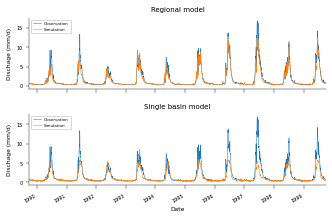

In [53]:
fig, ax = plt.subplots(figsize=cm2inch(12, 8), nrows=2, sharex=True)

regional_sim[basin]["1D"]["xr"]["QObs(mm/d)_obs"].sel(time_step=0).plot(ax=ax[0], label="Observation")
regional_sim[basin]["1D"]["xr"]["QObs(mm/d)_sim"].sel(time_step=0).plot(ax=ax[0], label="Simulation")

ax[0].set_xlim(single_sim[basin]["1D"]["xr"]["date"].values[0], single_sim[basin]["1D"]["xr"]["date"].values[-1])
ax[0].set_title('Regional model')
ax[0].set_xlabel('')
ax[0].set_ylabel("Dischage (mm/d)")
ax[0].legend()

single_sim[basin]["1D"]["xr"]["QObs(mm/d)_obs"].sel(time_step=0).plot(ax=ax[1], label="Observation")
single_sim[basin]["1D"]["xr"]["QObs(mm/d)_sim"].sel(time_step=0).plot(ax=ax[1], label="Simulation") #, color="C2")

ax[1].set_xlabel("Date")
ax[1].set_ylabel("Dischage (mm/d)")
ax[1].set_title("Single basin model")
ax[1].legend()

plt.tight_layout()
plt.savefig(FIGURE_DIR / "simulations_example_2plots.pdf", bbox_inches="tight", format="pdf")

# Regional model validation metric over epoch

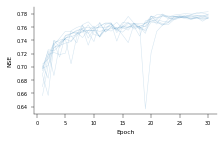

In [54]:
fig, ax = plt.subplots(figsize=cm2inch(8.3, 5))

for run_dir in (RUN_DIRS / "regional_model").glob('*'):
    event_file = more_itertools.one(list(run_dir.glob('event*')))
    validation_metrics = get_validation_data_as_series(event_file, name="regional_model")
    validation_metrics.plot(ax=ax, color="C0", alpha=0.2)
ax.set_ylabel("NSE")

plt.savefig(FIGURE_DIR / "regional_model_validation_over_epoch.pdf", bbox_inches="tight", format="pdf")

# Saturation plots

All saturation plots are generated for single seeds. If you want to check different seeds, adapt the ensemble_member variable.

## Regional model saturation limit

In [55]:
ensemble_member = 0

run_dir = more_itertools.one(list((RUN_DIRS / "regional_model").glob(f'*_ensemble_member_{ensemble_count}*')))

# Scaler are required to transform the saturation limit into mm/day space
scaler = nh_eval_utils.load_scaler(run_dir)  # xarray_feature_scale

# Get weight file, assuming that only the weight file of the best epoch exist.
weight_file = more_itertools.one(list(run_dir.glob('model_epoch*.pt')))
model_weights = torch.load(weight_file, map_location="cpu")

# Compute model saturation limit. For details see paper appendix.
regional_model_theoretical_limit = (model_weights['head.net.0.weight'].abs().sum() + model_weights['head.net.0.bias']).item() * scaler['xarray_feature_scale']["QObs(mm/d)"].data + scaler['xarray_feature_center']["QObs(mm/d)"].data

## Single basin model saturation limit

In [57]:
single_basin_to_theoretical_limit = {}
for run_dir in tqdm((RUN_DIRS / "single_basins_multi_forcings").glob(f'*_ensemble_member_{ensemble_count}_*'), total=529):
    # Basin is encoded at the beginning of the folder name
    basin = run_dir.stem.split('_')[0][-8:]
    
    # Get weight file, assuming that only the weight file of the best epoch exist.
    weight_file = more_itertools.one(list(run_dir.glob('model_epoch*.pt')))

    model_weights = torch.load(weight_file, map_location="cpu")
    scaler = nh_eval_utils.load_scaler(run_dir)

    single_basin_to_theoretical_limit[basin] = (model_weights['head.net.0.weight'].abs().sum() + model_weights['head.net.0.bias']).item() * scaler['xarray_feature_scale']["QObs(mm/d)"].data + scaler['xarray_feature_center']["QObs(mm/d)"].data


  0%|          | 0/529 [00:00<?, ?it/s]

## Number of timesteps above saturation limits

In [58]:
# Get train period statistics
data = {
    'obs_count_train_regional': {},
    'obs_count_train_single': {},
    'max_obs_train': {},
    'obs_count_test_regional': {},
    'obs_count_test_single':  {},
    'max_obs_test': {}
}

# Load obs for all basins from regional model result files
run_dir = more_itertools.one(list((RUN_DIRS / "regional_model").glob(f'*_ensemble_member_{ensemble_count}*')))
train_data_file = more_itertools.one(list((run_dir / "train").glob('*/train_results.p')))
with train_data_file.open("rb") as fp:
    train_results = pickle.load(fp)

for basin in tqdm(single_basin_to_theoretical_limit.keys()):
    ds = train_results[basin]["1D"]["xr"]
    
    data['obs_count_train_regional'][basin] = np.sum((ds["QObs(mm/d)_obs"] > regional_model_theoretical_limit).values)
    data['obs_count_train_single'][basin] = np.sum((ds["QObs(mm/d)_obs"] > single_basin_to_theoretical_limit[basin]).values)
    data['max_obs_train'][basin] = np.max(ds["QObs(mm/d)_obs"].values)

# Get test period statistics
run_dir = more_itertools.one(list((RUN_DIRS / "regional_model").glob(f'*_ensemble_member_{ensemble_count}*')))
test_data_file = more_itertools.one(list((run_dir / "test").glob('*/test_results.p')))
with test_data_file.open("rb") as fp:
    test_results = pickle.load(fp)

for basin in tqdm(single_basin_to_theoretical_limit.keys()):
    ds = test_results[basin]["1D"]["xr"]
    
    data['obs_count_test_regional'][basin] = np.sum((ds["QObs(mm/d)_obs"] > regional_model_theoretical_limit).values)
    data['obs_count_test_single'][basin] = np.sum((ds["QObs(mm/d)_obs"] > single_basin_to_theoretical_limit[basin]).values)
    data['max_obs_test'][basin] = np.max(ds["QObs(mm/d)_obs"].values)

saturation_df = pd.DataFrame(data)

  0%|          | 0/529 [00:00<?, ?it/s]

  0%|          | 0/529 [00:00<?, ?it/s]

## Merge data into one df

In [59]:
saturation_df['saturation_limit_regional'] = regional_model_theoretical_limit
saturation_df["saturation_limit_single"] = pd.Series(single_basin_to_theoretical_limit)
saturation_df

,obs_count_train_regional,obs_count_train_single,max_obs_train,obs_count_test_regional,obs_count_test_single,max_obs_test,saturation_limit_regional,saturation_limit_single
01550000,0,1,55.172394,0,2,81.939194,183.57038,36.591027
01451800,0,0,42.437290,0,0,42.437290,183.57038,42.576399
02014000,0,0,34.527641,0,1,45.892735,183.57038,36.285318
08194200,0,23,33.448895,0,3,11.525764,183.57038,4.190887
01484100,0,2,17.836697,0,5,29.101978,183.57038,15.290792
...,...,...,...,...,...,...,...,...
07301410,0,1,2.881109,0,2,2.665203,183.57038,1.717399
01435000,0,4,68.536110,0,3,70.522659,183.57038,57.389179
14236200,0,2,115.280510,0,5,140.749451,183.57038,77.358247
01057000,0,0,36.001221,0,0,33.815434,183.57038,36.429783


## Create plots

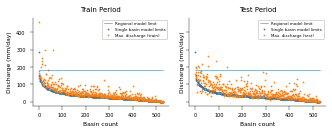

In [62]:
fig, ax = plt.subplots(figsize=cm2inch(12, 5), ncols=2, sharey=True)

saturation_df = saturation_df.sort_values(by='saturation_limit_single', ascending=False)

ax[0].plot(list(range(len(saturation_df))), saturation_df['saturation_limit_regional'], label='Regional model limit')
ax[0].scatter(list(range(len(saturation_df))), saturation_df['saturation_limit_single'], label='Single basin model limits', s=0.5)
ax[0].scatter(list(range(len(saturation_df))), saturation_df['max_obs_train'], label='Max. discharge (train)', s=0.5)

ax[0].set_xlabel("Basin count")
ax[0].set_ylabel("Discharge (mm/day)")
ax[0].legend()
ax[0].set_title('Train Period')


ax[1].plot(list(range(len(saturation_df))), saturation_df['saturation_limit_regional'], label='Regional model limit')
ax[1].scatter(list(range(len(saturation_df))), saturation_df['saturation_limit_single'], label='Single basin model limits', s=0.5)
ax[1].scatter(list(range(len(saturation_df))), saturation_df['max_obs_test'], label='Max. discharge (test)', s=0.5)

ax[1].set_xlabel("Basin count")
ax[1].set_ylabel("Discharge (mm/day)")
ax[1].legend()
ax[1].set_title('Test Period')

plt.tight_layout()
plt.savefig(FIGURE_DIR / "saturation_figure_combined.pdf", bbox_inches="tight", format="pdf")

# Performance over different Size splits

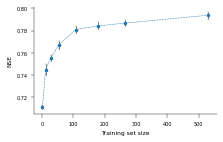

In [74]:
fig, ax = plt.subplots(figsize=cm2inch(8.3,5))
x, y, y_err = [], [], []

# single_basin
x.append(1)
y.append(df_single.median(axis=0).mean())
y_err.append(df_single.median(axis=0).std())

# size splits
for size_split in sorted(all_sizes):
    x.append(size_split)
    y.append(size_split_to_df[size_split].median(axis=0).mean())
    y_err.append(size_split_to_df[size_split].median(axis=0).std())

# Regional model
x.append(531)
y.append(df_regional.median(axis=0).mean())
y_err.append(df_regional.median(axis=0).std())

ax.errorbar(x, y, yerr=y_err, ls='--', marker='.', markersize=5, ecolor="black", capsize=1, capthick=0.2, label="Training size splits")


# ax.legend()
ax.set_xlabel("Training set size")
ax.set_ylabel("NSE")

plt.savefig(FIGURE_DIR / "performance_over_size_splits.pdf", bbox_inches="tight", format="pdf")

# Attribute- vs HUC- vs. Size-split

## Get number of basin pro attribute/huc split

In [75]:
cluster_counts = sorted(list(set([int(x.stem.split('_')[1]) for x in (RUN_DIRS / "attributes_cluster_splits").glob('*')])))
cluster_counts

cluster_to_basin_count = {}
for cluster_count in cluster_counts:
    # We can check the number of basins by looking at the test_metrics file of one ensemble member.
    run_dir = more_itertools.one([x for x in (RUN_DIRS / "attributes_cluster_splits").glob(f'cluster_{cluster_count}_*_experiment_name_0_*')])

    df = get_test_metrics(run_dir)
    cluster_to_basin_count[cluster_count] = len(df)

hucs = list(set([x.stem.split('_')[1] for x in (RUN_DIRS / "huc_splits").glob('*')]))
hucs

huc_to_basin_count = {}
for huc in hucs:
    # We can check the number of basins by looking at the test_metrics file of one ensemble member.
    run_dir = more_itertools.one([x for x in (RUN_DIRS / "huc_splits").glob(f'huc_{huc}_*_experiment_name_0_*')])

    df = get_test_metrics(run_dir)
    huc_to_basin_count[huc] = len(df)

## Create plot

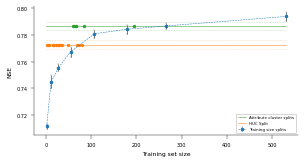

In [76]:
fig, ax = plt.subplots(figsize=cm2inch(12,6))
x, y, y_err = [], [], []

# single_basin
x.append(1)
y.append(df_single.median(axis=0).mean())
y_err.append(df_single.median(axis=0).std())

# size splits
for size_split in sorted(all_sizes):
    x.append(size_split)
    y.append(size_split_to_df[size_split].median(axis=0).mean())
    y_err.append(size_split_to_df[size_split].median(axis=0).std())

# Regional model
x.append(531)
y.append(df_regional.median(axis=0).mean())
y_err.append(df_regional.median(axis=0).std())

ax.errorbar(x, y, yerr=y_err, ls='--', marker='.', markersize=5, ecolor="black", capsize=1, capthick=0.2, label="Training size splits")

# Add attribute splits
y = df_attribute_splits.median(axis=0).mean()
std = df_attribute_splits.median(axis=0).std()
ax.plot([0, 531], [y, y], color="C2", label="Attribute cluster splits")
ax.plot([0, 531], [y-std, y-std], color="C2", alpha=0.3, ls='--')
ax.plot([0, 531], [y+std, y+std], color="C2", alpha=0.3, ls='--')
ax.scatter(list(cluster_to_basin_count.values()), [y]*len(cluster_to_basin_count), s=5, color="C2")

# Add huc splits
y = df_huc_splits.median(axis=0).mean()
std = df_huc_splits.median(axis=0).std()
ax.plot([0, 531], [y, y], color="C1", label='HUC Split')
ax.plot([0, 531], [y-std, y-std], color="C1", alpha=0.3, ls='--')
ax.plot([0, 531], [y+std, y+std], color="C1", alpha=0.3, ls='--')
ax.scatter(list(huc_to_basin_count.values()), [y]*len(huc_to_basin_count), s=5, color="C1")

ax.legend()
ax.set_xlabel("Training set size")
ax.set_ylabel("NSE")


plt.savefig(FIGURE_DIR / "attribute_vs_huc_vs_size_split.pdf", bbox_inches="tight", format="pdf")

# Approach compared to regional model

In [77]:
def compare_regional_to_other(df_regional, df_other, basins, alpha=0.05):
    regional_better_count = 0
    other_better_count = 0
    both_equal = 0
    for basin in basins:
        regional_values = df_regional.loc[basin].values
        other_values = df_other.loc[basin].values
        _, p_value = wilcoxon(regional_values, other_values)

        if (p_value < alpha) and (np.median(regional_values) > np.median(other_values)):
            regional_better_count += 1
        elif (p_value < alpha) and (np.median(regional_values) < np.median(other_values)):
            other_better_count += 1
        else:
            both_equal += 1
        
    return {'statistically different (worse)': regional_better_count, 'statistically different (better)': other_better_count, 'not statistically different': both_equal}

In [78]:
approach_compared_to_regional = {}

approach_compared_to_regional["single_basin"] = compare_regional_to_other(df_regional, df_single, basins)
approach_compared_to_regional["size_11"] = compare_regional_to_other(df_regional, size_split_to_df[11], basins)
approach_compared_to_regional["size_27"] = compare_regional_to_other(df_regional, size_split_to_df[27], basins)
approach_compared_to_regional["size_54"] = compare_regional_to_other(df_regional, size_split_to_df[54], basins)
approach_compared_to_regional["size_107"] = compare_regional_to_other(df_regional, size_split_to_df[107], basins)
approach_compared_to_regional["size_178"] = compare_regional_to_other(df_regional, size_split_to_df[178], basins)
approach_compared_to_regional["size_266"] = compare_regional_to_other(df_regional, size_split_to_df[266], basins)
approach_compared_to_regional["attribute_cluster"] = compare_regional_to_other(df_regional, df_attribute_splits, basins)
approach_compared_to_regional["huc_split"] = compare_regional_to_other(df_regional, df_huc_splits, basins)



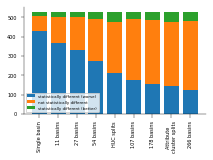

In [82]:
x_order = ['single_basin', 'size_11', 'size_27', 'size_54',  'huc_split', 'size_107', 'size_178', 'attribute_cluster', 'size_266']
approach_to_label = {
    'single_basin': "Single basin",
    'size_11': '11 basins',
    'size_27': '27 basins',
    'size_54': '54 basins',
    'huc_split': 'HUC splits',
    'size_107': '107 basins',
    'size_178': '178 basins',
    'attribute_cluster': 'Attribute \ncluster splits',
    'size_266': '266 basins',
}

fig, ax = plt.subplots(figsize=cm2inch(8.3, 5))
bottom = np.zeros(len(x_order))

for category in ["statistically different (worse)", "not statistically different", "statistically different (better)"]:
    values = []
    for approach in x_order:
        values.append(approach_compared_to_regional[approach][category])
    height = np.array(values)
    ax.bar([approach_to_label[x] for x in x_order], height, label=category, bottom=bottom)
    bottom += height
plt.xticks(rotation=90)

ax.legend()

plt.savefig(FIGURE_DIR / "approach_compared_to_regional.pdf", bbox_inches="tight", format="pdf")

# Maps

## Get Background map and gauge locations

As a background, we use the HUC 02 map provided in the CAMELS US dataset.

In [86]:
# Load Huc shape layer
gdf = gpd.read_file(PAPER_DIR / "misc" / "shapefiles" / "huc_02" / "huc_02_simplified.gdb")

# We remove Alaska, Hawaii region, and Carribean region
gdf = gdf.loc[~gdf.huc2.isin(['19', '20', '21', '22'])]

# Get gauge locations from CAMELS dataset
attributes_df = camelsus.load_camels_us_attributes(data_dir=CAMELS_DIR)

## Get basins per huc and attribute cluster

In [87]:
cluster_counts = sorted(list(set([int(x.stem.split('_')[1]) for x in (RUN_DIRS / "attributes_cluster_splits").glob('*')])))
cluster_counts

cluster_to_basin_ids = {}
for cluster_count in cluster_counts:
    # We can check the number of basins by looking at the test_metrics file of one ensemble member.
    run_dir = more_itertools.one([x for x in (RUN_DIRS / "attributes_cluster_splits").glob(f'cluster_{cluster_count}_*_experiment_name_0_*')])

    df = get_test_metrics(run_dir)
    cluster_to_basin_ids[cluster_count] = df.index.to_list()

hucs = list(set([x.stem.split('_')[1] for x in (RUN_DIRS / "huc_splits").glob('*')]))
hucs

huc_to_basin_ids = {}
for huc in hucs:
    # We can check the number of basins by looking at the test_metrics file of one ensemble member.
    run_dir = more_itertools.one([x for x in (RUN_DIRS / "huc_splits").glob(f'huc_{huc}_*_experiment_name_0_*')])

    df = get_test_metrics(run_dir)
    huc_to_basin_ids[huc] = df.index.to_list()

## Attribute split map

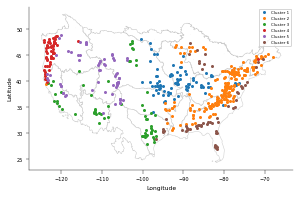

In [88]:
fig, ax = plt.subplots(figsize=cm2inch(12, 10))

gdf.plot(ax=ax, facecolor="white", edgecolor="#cccccc", linewidth=0.5)

for cluster, basins_ids in cluster_to_basin_ids.items():
    x = attributes_df.loc[basins_ids, 'gauge_lon'].values
    y = attributes_df.loc[basins_ids, 'gauge_lat'].values
    ax.scatter(x, y, color=f"C{cluster}", label=f"Cluster {int(cluster)+1}")


ax.legend()
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.savefig(FIGURE_DIR / "map_attribute_split.pdf", bbox_inches="tight", format="pdf")


## HUC split

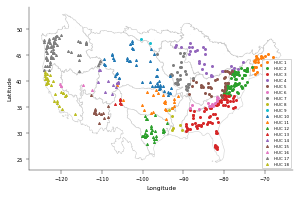

In [103]:
fig, ax = plt.subplots(figsize=cm2inch(12, 10))

gdf.plot(ax=ax, facecolor="white", edgecolor="#cccccc", linewidth=0.5)

for huc, basin_ids in sorted(huc_to_basin_ids.items()):
    x = attributes_df.loc[basin_ids, 'gauge_lon'].values
    y = attributes_df.loc[basin_ids, 'gauge_lat'].values
    if int(huc) < 10:
        marker = 'o'
        color = f"C{int(huc)}"
    else:
        marker = '^'
        color = f"C{int(huc) - 10}"
    ax.scatter(x, y, color=color, marker=marker, label=f"HUC {int(huc)}")


ax.legend()
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.savefig(FIGURE_DIR / "map_huc_split.pdf", bbox_inches="tight", format="pdf")


## Size split

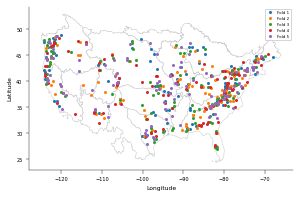

In [98]:
split = '107'
ensemble_count = 0

fig, ax = plt.subplots(figsize=cm2inch(12, 10))

gdf.plot(ax=ax, facecolor="white", edgecolor="#cccccc", linewidth=0.5)

# Find all directories which belong to this size split.
for i, run_dir in enumerate((RUN_DIRS / "size_splits").glob(f'size_{split}_*_experiment_name_{ensemble_count}_*')):

    # Find the test_metrics.csv file and raise and error if more than one exist.
    test_file = list((run_dir / "test").glob('*/test_metrics.csv'))
    test_file = more_itertools.one(test_file)

    _df = pd.read_csv(test_file, dtype={'basin': str})
    basins = _df["basin"].to_list()
    
    x = attributes_df.loc[basins, 'gauge_lon'].values
    y = attributes_df.loc[basins, 'gauge_lat'].values

    # if i < 10:
    #     marker = '.'
    #     color = f"C{i}"
    # else:
    #     marker = '^'
    #     color = f"C{i - 10}"

    ax.scatter(x, y, label=f"Fold {i + 1}")

ax.legend()
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.savefig(FIGURE_DIR / "map_size_split.pdf", bbox_inches="tight", format="pdf")
